# Import libraries

In [3]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np

from ipywidgets import interact
import scipy.spatial.distance as SSD
from skimage.filters import threshold_otsu, threshold_local

In [59]:
# Equação: (u-mi)^T @ A^{-1} @ (u-mi)
# Passos para cálculo da matriz de covariância = A
''' 
Passo 01: média da variável.

    ||u - mi ||, dado que:
        * u = pixel da imagem
        * mi = média de cada uma das componentes - R,G,B. É um vetor
        
Passo 02: cálculo da variância de cada uma das componentes em relação a componente média.

    sigma_r, sigma_g, sigma_b
    Pega cada uma das componentes de entrada, menos mi em termos quadráticos
    
Passo 03: matriz de covariância o quanto componente varia ou individualmente ou conjuntamente

A = sigma_red_red    sigma_red_green    sigma_red_blue
    sigma_green_red  sigma_green_green  sigma_green_blue
    sigma_blue_red   sigma_blue_green   sigma_blue_blue

Passo 04: Cálculo da inversa da matriz de covariância, A^{-1}

'''
def mahalanobis(img):
    # colors: https://flaviocopes.com/rgb-color-codes/
    #  firebrick	#B22222	(178,34,34)
    #  tomato	    #FF6347	(255,99,71)
    #  dark orange	#FF8C00	(255,140,0)
    # passo 01
    img_red   = img[:,:,0]
    img_green = img[:,:,1]
    img_blue  = img[:,:,2]

    mean_red   = np.mean(img[:,:,0])
    mean_green = np.mean(img[:,:,1])
    mean_blue  = np.mean(img[:,:,2])

    mi = np.array([mean_red, mean_green, mean_blue])
    #mi = np.array([184,134,11])
    
    # (u-mi)^T @ A^{-1} @ (u-mi)
    # passo 02
    # N = pontos de entrada
    #sigma_red = (1 / N-1) * np.sum((u - mean_red)**2)
    #sigma_green = (1 / N-1) * np.sum((u - mean_green)**2)
    #sigma_blue = (1 / N-1) * np.sum((u - mean_blue)**2)
    
    # matriz de covariância
    covariance = np.cov([img_red.ravel(), img_green.ravel(), img_blue.ravel()])
    inv_cov = np.linalg.inv(covariance) # inv. covariance matrix
    
    height = img.shape[0]
    weigth = img.shape[1]
    
    result = np.zeros_like(img, dtype='float64')
    
    for h in range(height):
        for w in range(weigth):
            # array with particular pixels from each image
            u = np.array([img_red[h, w], img_green[h, w],img_blue[h, w]])
            
            # calculate mahalanobis distance and insert value as a pixel
            # scipy.spatial.distance.mahalanobis(u, mi, A^{-1})
            # sqrt(u-mi)A^{-1} * (u-mi).T
            #result[h, w] = SSD.mahalanobis(u, mi, inv_cov)
            result[h, w] = SSD.mahalanobis(u, mi, inv_cov)
    return result


# Import data

In [60]:
DATA_DIR = '/home/victor/Mestrado/Disciplinas/Visão Computacional/Projeto Final/bowfire/BowFire'
IMG_DIR = os.path.join(DATA_DIR, 'images')
MASK_DIR = os.path.join(DATA_DIR, 'masks')

In [61]:
list_imgs = [os.path.join(IMG_DIR, x) for x in os.listdir(IMG_DIR)]
list_masks = [os.path.join(MASK_DIR, x) for x in os.listdir(MASK_DIR)]

list_imgs = sorted(list_imgs)
list_masks = sorted(list_masks)

print('Total de imagens', len(list_imgs))
print('Total de máscaras', len(list_masks))

Total de imagens 119
Total de máscaras 119


# Adaptative Threshold

In [68]:
@interact(count = (0, len(list_imgs)), block_size = (0,50,1), offset = (0,50,1))
def _(count, block_size, offset):
    global img
    global std_img
    global mask
    global binary_global
    
    
    mask =cv2.imread(list_masks[count])
    
    img =cv2.imread(list_imgs[count], cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #img = img / 255.0
    
    std_img =  (img - np.mean(img)) / np.std(img)
    
    gray = cv2.imread(list_imgs[count], cv2.IMREAD_GRAYSCALE)
    #gray = gray / 255.0
    
    global_thresh = threshold_otsu(gray)
    binary_global = gray > global_thresh

    block_size = 35
    adaptive_thresh = threshold_local(gray, block_size, offset=offset)
    binary_adaptive = gray > adaptive_thresh

    
    fig, ax = plt.subplots(2,2, figsize=(10,5))
    ax[0,0].imshow(np.squeeze(img))
    ax[0,0].set_title('original')
    ax[0,0].axis('Off')
    
    ax[0,1].imshow(mask)
    ax[0,1].set_title('mask')
    ax[0,1].axis('Off')
    
    ax[1,0].imshow(binary_global, 'gray')
    ax[1,0].set_title('global_thresh')
    ax[1,0].axis('Off')
    
    ax[1,1].imshow(binary_adaptive,'gray')
    ax[1,1].set_title('adaptive_thresh')
    ax[1,1].axis('Off')

interactive(children=(IntSlider(value=59, description='count', max=119), IntSlider(value=25, description='bloc…

# Color Threshold

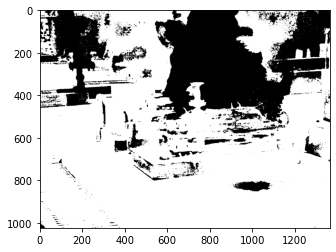

In [39]:
def color_threshold(img, kernel_opening=5, kernel_closing=5):
    #global masked_img
    
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    #gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    #lower_blue= np.array([105,105,105])
    #upper_blue = np.array([255,255,255])
    
    lower_blue= np.array([10,10,10])
    upper_blue = np.array([150,150,255])
    
    mask = cv2.inRange(hsv,lower_blue,upper_blue)
    masked_img = cv2.bitwise_and(img, img, mask=mask)
    
    plt.imshow(mask,'gray')
color_threshold(img)

# Mahalanobis Distance

The formula to compute Mahalanobis distance is as follows:

$D^2 = (x-m)^{T} \cdot C^{-1} \cdot (x-m)$

**Where,**



$D^2$ is the square of the Mahalanobis distance. 

$x$          is the vector of the observation (row in a dataset), 

$m$          is the vector of mean values of independent variables (mean of each column), 

$C^{-1}$     is the inverse covariance matrix of independent variables. 

---

$(x – m)$ is essentially the distance of the vector from the mean. We then divide this by the covariance matrix (or multiply by the inverse of the covariance matrix).

If you think about it, this is essentially a multivariate equivalent of the regular standardization (z = (x – mu)/sigma). That is, z = (x vector) – (mean vector) / (covariance matrix).

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


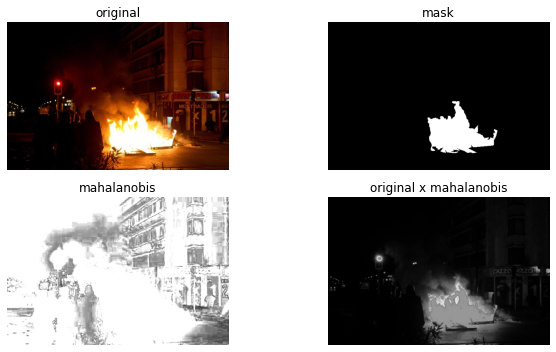

In [85]:
# recebe a img e a mask da função da célula acima

#@interact(count = (0, len(list_imgs)))
def view_images(img):
    global gray
    global mahalanobis_img
    global multiply_img
    
    #gray = cv2.imread(list_imgs[count], cv2.IMREAD_GRAYSCALE)
    #gray = gray / 255.0
    
    mahalanobis_img = mahalanobis(img)
    img = img/255
    multiply_img = cv2.multiply(img[:,:,0], (mahalanobis_img[:,:,0]))
    #multiply_img[multiply_img>=1.0] = 1
    #multiply_img[multiply_img<=0.5] = 0

    
    fig, ax = plt.subplots(2,2, figsize=(10,5))
    ax[0,0].imshow(img, 'gray')
    ax[0,0].set_title('original')
    ax[0,0].axis('Off')
    
    ax[0,1].imshow(mask)
    ax[0,1].set_title('mask')
    ax[0,1].axis('Off')
    
    ax[1,0].imshow(mahalanobis_img, 'gray')
    ax[1,0].set_title('mahalanobis')
    ax[1,0].axis('Off')
    
    ax[1,1].imshow(multiply_img, 'gray')
    ax[1,1].set_title('original x mahalanobis')
    ax[1,1].axis('Off')
    
    plt.tight_layout()

#view_images(std_img)
view_images(img)

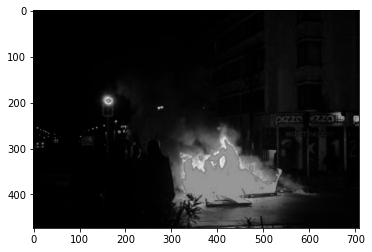

In [73]:
plt.imshow(multiply_img, 'gray')

In [75]:
@interact(ksize = (1, 51, 2), sigmaX = (0.1, 10.0, 0.1))
def gaussian_blur(ksize, sigmaX):
    global blurred
    blurred = cv2.GaussianBlur(multiply_img, ksize = (ksize, ksize), sigmaX = sigmaX)
    plt.imshow(blurred, 'gray')

interactive(children=(IntSlider(value=25, description='ksize', max=51, min=1, step=2), FloatSlider(value=5.0, …

In [76]:
def fire_bounds(img, kernel='normal',kernel_opening=5, kernel_closing=5):
    global opening
    global closing
    
    # opening
    if kernel == 'normal':
        kernel_open = np.array([kernel_opening, kernel_opening])
        opening = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel_open)

        # closing
        kernel_close = np.array([kernel_closing, kernel_closing])
        closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel_close)
        masked_with_morpho = cv2.multiply(img, (closing//255))

        fig, ax = plt.subplots(1,3, figsize = (15,5))
        ax[0].imshow(np.squeeze(img),'gray')
        ax[0].set_title('original img')
        ax[1].imshow(np.squeeze(opening), 'gray')
        ax[1].set_title('opening')
        ax[2].imshow(np.squeeze(closing), 'gray')
        ax[2].set_title('closing')

    else:
        kernel_open = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(kernel_opening, kernel_opening))
        opening = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel_open)

        # closing
        kernel_close = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(kernel_closing, kernel_closing))
        closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel_close)
        masked_with_morpho = cv2.multiply(img, (closing//255))
        
        fig, ax = plt.subplots(1,3, figsize = (15,5))
        ax[0].imshow(np.squeeze(img),'gray')
        ax[0].set_title('original img')
        ax[1].imshow(np.squeeze(opening), 'gray')
        ax[1].set_title('opening')
        ax[2].imshow(np.squeeze(closing), 'gray')
        ax[2].set_title('closing')

        for axs in ax:
            axs.axis('Off')

In [80]:
@interact(count = (0, len(list_imgs)), 
          kernel = ['normal','ellipse'],
          kernel_opening = (1,20,1), kernel_closing = (1,30,1))

def config_bounds(count, kernel, kernel_opening, kernel_closing):
    #global img
    #global mask    
    fire_bounds(blurred, kernel_opening, kernel_closing)
        
# open = 3
# close = 20

interactive(children=(IntSlider(value=59, description='count', max=119), Dropdown(description='kernel', option…

In [84]:
@interact(thresh = (0.0, 5.0))
def view_th(thresh):
    global threshed_img
    #new_img = cv2.multiply(multiply_img, (closing))

    th, threshed_img = cv2.threshold(closing, thresh, 255, cv2.THRESH_BINARY)
    
    plt.imshow(threshed_img, 'gray');

interactive(children=(FloatSlider(value=2.5, description='thresh', max=5.0), Output()), _dom_classes=('widget-…

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


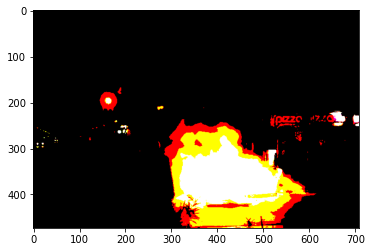

In [33]:
final_img = cv2.multiply(closing, (threshed_img))
plt.imshow(final_img,'gray')

# Mahalanobis Distance


        Mahalonobis distance is the distance between a point and a distribution. 
        And not between two distinct points. 
        It is effectively a multivariate equivalent of the Euclidean distance.

https://www.machinelearningplus.com/statistics/mahalanobis-distance/

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


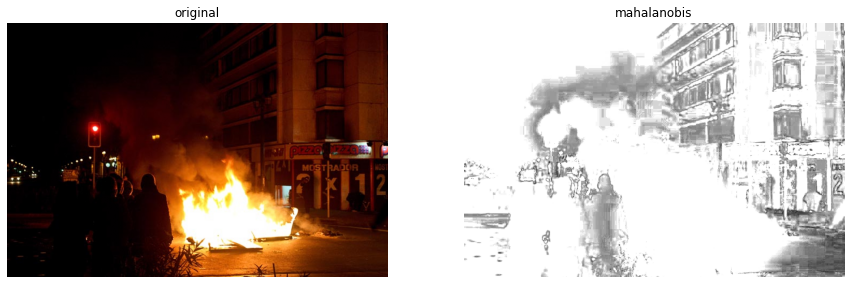

In [134]:
# Equação: (u-mi)^T @ A^{-1} @ (u-mi)
# Passos para cálculo da matriz de covariância = A
''' 
Passo 01: média da variável.

    ||u - mi ||, dado que:
        * u = pixel da imagem
        * mi = média de cada uma das componentes - R,G,B. É um vetor
        
Passo 02: cálculo da variância de cada uma das componentes em relação a componente média.

    sigma_r, sigma_g, sigma_b
    Pega cada uma das componentes de entrada, menos mi em termos quadráticos
    
Passo 03: matriz de covariância o quanto componente varia ou individualmente ou conjuntamente

A = sigma_red_red    sigma_red_green    sigma_red_blue
    sigma_green_red  sigma_green_green  sigma_green_blue
    sigma_blue_red   sigma_blue_green   sigma_blue_blue

Passo 04: Cálculo da inversa da matriz de covariância, A^{-1}

'''
def mahalanobis(img):
    # passo 01
    img_red   = img[:,:,0]
    img_green = img[:,:,1]
    img_blue  = img[:,:,2]

    mean_red   = np.mean(img[:,:,0])
    mean_green = np.mean(img[:,:,1])
    mean_blue  = np.mean(img[:,:,2])

    mi = np.array([mean_red, mean_green, mean_blue])

    # (u-mi)^T @ A^{-1} @ (u-mi)
    # passo 02
    # N = pontos de entrada
    #sigma_red = (1 / N-1) * np.sum((u - mean_red)**2)
    #sigma_green = (1 / N-1) * np.sum((u - mean_green)**2)
    #sigma_blue = (1 / N-1) * np.sum((u - mean_blue)**2)
    
    # matriz de covariância
    covariance = np.cov([img_red.ravel(), img_green.ravel(), img_blue.ravel()])
    inv_cov = np.linalg.inv(covariance) # inv. covariance matrix
    
    height = img.shape[0]
    weigth = img.shape[1]
    
    result = np.zeros_like(img, dtype='float64')
    
    for h in range(height):
        for w in range(weigth):
            # array with particular pixels from each image
            v = np.array([img_red[h, w], img_green[h, w],img_blue[h, w]])
            # calculate mahalanobis distance and insert value as a pixel
            result[h, w] = SSD.mahalanobis(v, mi, inv_cov)
    return result

new_img = mahalanobis(img)

fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].imshow(img)
ax[0].set_title('original')
ax[1].imshow(new_img)
ax[1].set_title('mahalanobis')


for axs in ax:
    axs.axis('Off')

In [135]:
def _(msg=True):
    if msg == True:
        return 'true'
    else:
        return 'False'
_(False)

'False'